<a href="https://murmuration-sas.com/" target="_blank">
    <img src="https://murmuration-sas.com/wp-content/uploads/2017/05/Logo-murmuration-vert.png" alt="Murmuration" style="width: 100px" align="right" />
</a>


# Sea-water Quality
____________


<p style="text-align: right"> Tutorial created by-Maël Plantec</p>

## Synopsis

[1. Data description](#data_description) <br>
[2. Dependencies](#dependencies) <br>
[3. Import required libraries](#import_libraries) <br>
[4. Open and view zarr](#open_zarr) <br>
[5. Plot map](#plot_map) <br>
[6. Masking xarrays](#masking_xarrays) <br>
[7. Plot the evolution of compound](#plotting_evolution) <br>
[8. Resample the data and plot the evolution of compound](#resample) <br>
[9. Save to netCDF4 file](#save_to_netcdf) <br>
[10. Save externally as geoTIF](#save_as_geotiff) <br>
[11. Convert xarray to pandas dataframe](#convert_to_df) <br>
[12. Sources](#sources) <br> 

## <a id='data_description'></a>1. Data description

- Water quality indicator has a temporal coverage between 1 January 2020 and (J-4)th day.
- The spatial coverage includes the whole earth seas and oceans but only the European region (west =25.0° W, east=45.0° E, south=30.0° N, north=70.0° N) for this exercise. 
- The data is measured at multiple levels of depth below the surface (but only the surface is of interest here and is available daily. 
- The physical data (temperature and salinity) has a spatial resolution of 0.1° which corresponds to 10 km near the equator. The biochemestry data (ph, concentration of chlorophylla and CO2 pressure) has a resolution of 30 km.
- The indicator has 5 sub-indicators (2 physical and 3 biochemstry indicators) :
    - thetao - Sea water potential temperature - ° C
    - so - Sea water salinity - S.m-1 (siemens by meter)
    - ph - Sea water pH reported on total scale (pH scale)
    - chl - Mass concentration of chlorophyll a in sea water - mg/m3
    - spco2 - Surface partial pressure of carbon dioxide in sea water - Pa

## <a id='dependencies'></a>2. Dependencies

The following packages are required to run the scripts below.

- xarray
- fsspec
- Pandas
- Plotly

## <a id='import_libraries'></a>3. Import required libraries

In [ ]:
import numpy as np
import xarray as xr
import fsspec
import pandas as pd
import plotly.express as px
import plotly
import warnings
warnings.filterwarnings('ignore')
plotly.offline.init_notebook_mode()

## <a id='open_zarr'></a>4. Open and view zarr

- The data is stored on a S3 in the zarr format, which is a cloud optimised format for storing geospatial raster data. It can be opened using the fsspec library.
- The 5 sub-indicators are found in 5 different zarr files and they can accesed separately by simply mentioning the zarrfile name in the repo. 
- The available zarrfiles are:
    - chlorophylla.zarr
    - co2pressure.zarr
    - ph.zarr
    - salinity.zarr
    - temperature.zarr

In [ ]:
repo = "salinity.zarr"
url = "https://storage.gra.cloud.ovh.net/v1/AUTH_0c2c27fc2c8b4a7d97a35ea0e2911f9b/murmuration-cassini/sea-water-quality/"
ds = xr.open_zarr(fsspec.get_mapper(url + repo))

In [ ]:
ds

## <a id='plot_map'></a>5. Plot map

Select a particular date and a compound to view it in a map. The longitude values are converted from the format (0 to 360) to (-180 to 180) to make the process easy. 

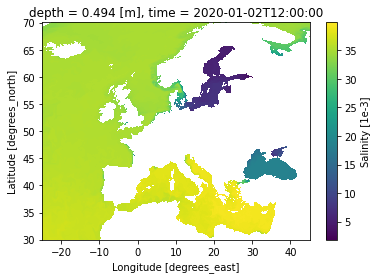

In [3]:
ds.sel(time = "2020-01-02T12:00:00.000000000")["so"].plot()

## <a id='masking_xarrays'></a>6. Masking xarrays

Create a mask using where function to replace the value with nan where the condition fails. Use the argument drop to drop those entries

In [ ]:
mask_lon = (ds.longitude >= -15) & (ds.longitude <= 15)
ds_masked = ds.where(mask_lon, drop=True)
ds_masked = ds_masked.sel(latitude = slice(35, 50))

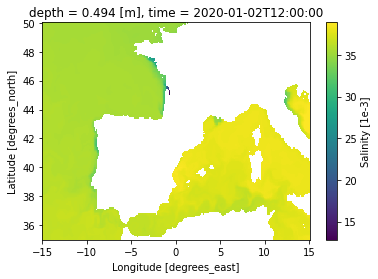

In [5]:
ds_masked["so"].sel(time = "2020-01-02T12:00:00.000000000").plot()

## <a id='plotting_evolution'></a>7. Plot the evolution of compound

The dataset is rich in both spatial and temporal extension. It is possible to plot the evolution of a specififc compound over time directly using plot function. But in order to have more freedom and to improve the aesthetics of the charts, it can be made using plotly express. To plot the time series evolution, a single point in the grid has to chosen. 

In [ ]:
so = ds.sel(latitude = 30.166666, longitude = -24.833334)["so"].values.tolist()
so = [item for sublist in so for item in sublist]
time = list(ds["time"].values)

In [ ]:
fig = px.line(x=time, y=so, title='Evolution of Salinity - Daily', labels={'x': 'Time', 'y':'Salinity (S.m-1)'})
fig.show()

## <a id='resample'></a>8. Resample the data and plot the evolution of compound

The data can be resampled to any higher order to time according to the python datetime conventions. For example, "D" or "1D" represents 1 day, "2D" represents two days. 

In [ ]:
so = ds.sel(latitude = 30.166666, longitude = -24.833334).resample(time="M").mean()["so"].values.tolist()
so = [item for sublist in so for item in sublist]
time = list(ds.resample(time="M").mean()["time"].values)

In [ ]:
fig = px.line(x=time, y=so, title='Evolution of Salinity - Monthly', labels={'x': 'Time', 'y':'Salinity (S.m-1)'})
fig.show()

## <a id='save_to_netcdf'></a>9. Save to netCDF4 file

The data can be subsetted nad stored into a netCDF4 file to use it in other tools or softwares. 

In [ ]:
ds_to_nc = ds.sel(time = slice("2020-01-02T12:00:00.000000000", "2020-01-04T12:00:00.000000000"))
ds_to_nc.to_netcdf("ds_to_nc.nc")

## <a id='save_as_geotiff'></a>10. Save externally as geoTIF

The whole data or a part of it can be saved externally into a raster file (geoTIF) to use it in other applications like QGIS, ArcGIS etc. Since here the data is very huge, a part of it has to be selected before saving it tro a geoTIF file. 

In [ ]:
ds_to_save = ds_masked["so"].sel(time = "2020-01-02T12:00:00.000000000")
ds_to_save

In [ ]:
ds_to_save.rio.to_raster("ds_to_save.tif")

## <a id='convert_to_df'></a>11. Convert xarray to pandas dataframe

Since some of the conputations and charts requires the data to be in a dataframe format, a part or whole of the data can be converted to a daraframe using the following code snippets. 

In [ ]:
mask_lon2 = (ds.longitude >= -12) & (ds.longitude <= -10)
ds_temp = ds.where(mask_lon2, drop=True)
ds_temp = ds_temp.sel(latitude = slice(50, 52))
ds_temp = ds_temp.sel(time = slice("2020-01-02T12:00:00.000000000", "2020-01-03T12:00:00.000000000"))

In [ ]:
ds_to_df = ds_temp.to_dataframe()

In [ ]:
ds_to_df = ds_temp.to_dataframe()
ds_to_df = ds_to_df.reset_index()

In [13]:
ds_to_df.head()

time     depth  latitude  longitude         so
0 2020-01-02 12:00:00  0.494025      50.0 -12.000000  35.412151
1 2020-01-02 12:00:00  0.494025      50.0 -11.916667  35.410625
2 2020-01-02 12:00:00  0.494025      50.0 -11.833333  35.409100
3 2020-01-02 12:00:00  0.494025      50.0 -11.750000  35.409100
4 2020-01-02 12:00:00  0.494025      50.0 -11.666667  35.409100

## <a id='sources'></a>12. Sources

- https://docs.xarray.dev/en/stable/index.html
- https://www.wekeo.eu/data?view=viewer
- https://plotly.com/python/